In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import glob
import cv2
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from scipy.ndimage.morphology import generate_binary_structure

In [2]:
images = glob.glob('vehicles/*/*.png')
cars = []
for image in images:
    cars.append(image)

images = glob.glob('non-vehicles/*/*.png')
notcars = []
for image in images:
    notcars.append(image)

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [4]:

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [6]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, None] # Min and max in y to search in slide_window()

In [7]:
t = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(t2-t,'seconds taken to extract features')

125.06576228141785 seconds taken to extract features


In [8]:
print(len(car_features))
print(len(notcar_features))
#car_features = car_features[:len(notcar_features)]
#notcar_features = np.vstack((notcar_features, notcar_features,notcar_features))
print(len(car_features))


8792
8968
8792


In [9]:
### building features and labels and normalize the data
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [10]:
### test train split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [11]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
4.42 Seconds to train SVC...
Test Accuracy of SVC =  0.9907


In [12]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [13]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [14]:
"""
sizeofwindow = [(75, 75), (100, 100), (125, 125)]
startrowofwindow = [(360, 560), (380, 640), (400, 720)]
overlapratio = (0.75, 0.75)

def slide_window(img):
    # Accumulate the list of windows to be searched.
    window_list = []
    
    # Process each window size.
    for (xy_window, y_start_stop) in zip(sizeofwindow, startrowofwindow):
        # Set the start and stop regions to scan.
        x_start = 0
        x_stop = img.shape[1]
        y_start = y_start_stop[0]
        y_stop = y_start_stop[1]
    
        # Compute the span of the region to be searched.
        xspan = x_stop - x_start
        yspan = y_stop - y_start
        
        # Compute the step between successive windows.
        nx_pix_per_step = np.int(xy_window[0] * (1. - overlapratio[0]))
        ny_pix_per_step = np.int(xy_window[1] * (1. - overlapratio[1]))
        # Compute the number of windows to generate at this size.
        nx_windows = int(xspan/nx_pix_per_step) - 1
        ny_windows = int(yspan/ny_pix_per_step) - 1
        # Loop through the x and y positions to find the window coordinates.
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate the window position. Since we are more considered about
                # vehicles in our half of the road, start the windows from the lower
                # right and move up and to the left.
                startx = xs*nx_pix_per_step + x_start
                endx = startx + xy_window[0]
                starty = ys*nx_pix_per_step + y_start
                endy = starty + xy_window[1]
                # Append window position to the list.
                window_list.append(((startx, starty), (endx, endy)))
                
    # Return the list of windows.
    return window_list
"""

print(y_start_stop)
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, xy_overlap=(0.75, 0.75), min_max = (75,125)):
    # If x and/or y start/stop positions not defined, set to image size
        
        # Compute the span of the region to be searched    
        
        # Compute the number of pixels per step in x/y
        window_list = []
        x_start_stop = np.zeros(2, dtype = np.int)
        for x in range(min_max[0],min_max[1], 25):
            
            x_start_stop[0] = 0
            x_start_stop[1] = img.shape[1]
            #y_start_stop[0] = 0
            y_start_stop[1] = img.shape[0]
                
            xspan = x_start_stop[1] - x_start_stop[0]
            yspan = y_start_stop[1] - y_start_stop[0]
            
            nx_pix_per_step = np.int(x*(1 - xy_overlap[0]))
            ny_pix_per_step = np.int(x*(1 - xy_overlap[1]))
            # Compute the number of windows in x/y
            nx_windows = np.int(xspan/nx_pix_per_step) - 1
            ny_windows = np.int(yspan/ny_pix_per_step) - 1
            # Initialize a list to append window positions to
            # Loop through finding x and y window positions
            # Note: you could vectorize this step, but in practice
            # you'll be considering windows one by one with your
            # classifier, so looping makes sense
            for ys in range(ny_windows):
                for xs in range(nx_windows):
                    # Calculate window position
                    startx = xs*nx_pix_per_step + x_start_stop[0]
                    endx = startx + x
                    starty = ys*ny_pix_per_step + y_start_stop[0]
                    endy = starty + x

                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list


[350, None]


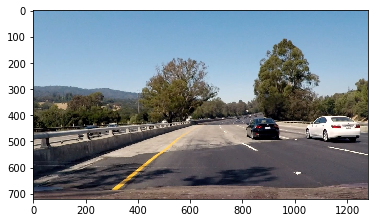

28


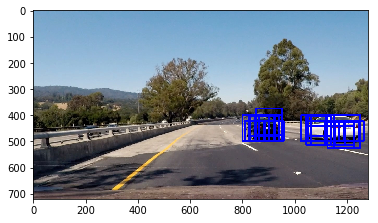

In [21]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=6, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

# Split up data into randomized training and test sets

# Use a linear SVC 

# Check the score of the SVC
# Check the prediction time for a single sample
t=time.time()

test_images = glob.glob('test_images/test*.jpg')
image = cv2.imread(test_images[4])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
draw_image = np.copy(image)
plt.imshow(image)
plt.show()
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
#windows = slide_window(image)

windows = slide_window(image, xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  

print(len(hot_windows))

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()



In [22]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, heatmap):
    # Generate the labels from the heat map.
    #s = generate_binary_structure(2,2)
    labels = label(heatmap)#,structure=s)
    # Keep a list of bboxes for detected vehicles.
    bboxes = []
    # Iterate through all detected vehicles.
    for vehicle in range(1, labels[1]+1):
        # Find pixels with each vehicle label value.
        nonzero = (labels[0] == vehicle).nonzero()
        # Identify x and y values of those pixels.
        nonzerox = np.array(nonzero[0])
        nonzeroy = np.array(nonzero[1])
        # Define a bounding box based on the min/max x and y.
        bbox = ((np.min(nonzeroy), np.min(nonzerox)), (np.max(nonzeroy), np.max(nonzerox)))
        bboxes.append(bbox)
    # Draw the bounding boxes for the detected vehicles.
    img = draw_boxes(img, bboxes)
    # Return the annotated image.
    return img

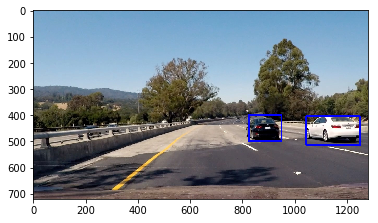

In [23]:
heatmap = np.zeros((image.shape[0], image.shape[1]), np.uint8)
heatmap = add_heat(heatmap, hot_windows)
heatmap = apply_threshold(heatmap, 2) 
final_image = draw_labeled_bboxes(image, heatmap)    
plt.imshow(final_image)
plt.show()    

In [24]:
def Vehicle_detect(image):
    windows = slide_window(image, xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    heatmap = np.zeros((image.shape[0], image.shape[1]), np.uint8)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 2) 
    final_image = draw_labeled_bboxes(image, heatmap)
    
    return final_image

In [ ]:
from moviepy.editor import VideoFileClip
video_output = 'project5_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_output, audio=False)